# Backscattering normalization

Ref: 10.1109/tgrs.2012.2205264, https://ieeexplore.ieee.org/document/6264094 (Mladenova (2013))

In [1]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

In [2]:
def skew_gauss(x, A, mean, dev, alpha,):
    """Skew, not-normalized and shifted gaussian distribution.

    References:
    - https://www.wolframalpha.com/input?i=skew+gaussian+distribution
    - https://stackoverflow.com/questions/15400850/scipy-optimize-curve-fit-unable-to-fit-shifted-skewed-gaussian-curve
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

    """
    
    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

#-----------------------------------------------------------------------------

def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    
    import math
    
    pdf = (1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))
    return A*pdf

#-----------------------------------------------------------------------------

def HIST_norm(ref_mean, ref_std, obs:list):
    """HIST normalization
    Ref. Mladenova, 2013, https://ieeexplore.ieee.org/document/6264094
    
    obs = [value, mean, std]
    """
    value, mean, std = obs
    return ref_mean+ref_std/std*(value-mean)

#-----------------------------------------------------------------------------

In [3]:
df = pd.read_csv('..\\Data\\Golden_GEE.csv', delimiter='\t', index_col=0); df

,Angle[°],Date,Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],VV_norm[dB],VH_norm[dB]
0,31.282551,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,0.009136,0.000018,0.070329,0.000630,-11.528672,-20.392462,0.038881,0.008441,0.170173,0.0,0.0,8.7339,-12.343922,-20.828488
1,41.103306,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,0.006342,0.000010,0.090708,0.001534,-10.423533,-21.977589,0.073466,0.006573,0.147105,0.0,0.0,11.8548,-10.423533,-21.977589
2,37.537476,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,0.005942,0.000007,0.062548,0.000390,-12.037891,-22.260785,0.027052,0.004964,0.150527,0.0,0.0,15.6591,-11.275126,-21.874069
3,31.368000,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,0.006690,0.000009,0.066282,0.000831,-11.786029,-21.745415,0.054418,0.005718,0.159550,0.0,0.0,8.5507,-12.548264,-22.056497
4,41.305325,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,0.005057,0.000007,0.056139,0.000400,-12.507326,-22.961495,0.030916,0.005962,0.160673,0.0,0.0,10.5575,-12.507326,-22.961495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,41.293633,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,0.011202,0.000027,0.093611,0.000985,-10.286710,-19.507143,0.045695,0.010312,0.155637,0.0,0.0,5.1388,-10.286710,-19.507143
103,37.531326,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,0.012791,0.000031,0.069743,0.000667,-11.565022,-18.931034,0.041511,0.010434,0.155525,0.0,0.0,14.4822,-10.849906,-18.851762
104,31.386597,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,0.010243,0.000017,0.159341,0.004745,-7.976737,-19.895653,0.129336,0.007121,0.167105,0.0,0.0,4.9978,-9.523675,-20.377558
105,41.307350,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,0.011606,0.000018,0.090067,0.000921,-10.454340,-19.353215,0.044419,0.006885,0.124052,NaN,0.0,NaN,-10.454340,-19.353215


In [4]:
normdict = dict()
nnormdict = dict()

for orb in [168, 117, 95]:
    d = dict()
    for pol in ['VV','VH']:
        d[f'{pol}']      = df.loc[df.Orb==orb][f'{pol}[dB]'].values
        d[f'{pol}_mean'] = np.mean(df.loc[df.Orb==orb][f'{pol}[dB]'].values)
        d[f'{pol}_std']  = np.std(df.loc[df.Orb==orb][f'{pol}[dB]'].values)
    d['angle'] = df.loc[df.Orb==orb][f'Angle[°]'].values
    normdict[orb] = d
    
normdf = pd.DataFrame.from_dict(normdict, orient='index'); normdf

statsnorm = normdf.drop(columns=['VV','VH','angle']); statsnorm

,VV_mean,VV_std,VH_mean,VH_std
168,-7.851597,2.030503,-16.728468,2.979246
117,-9.979681,1.792887,-17.444914,2.979192
95,-9.424314,1.612225,-17.502859,2.704117


In [12]:
for orb in [168, 117, 95]:
    d = dict()
    for pol in ['VV', 'VH']:
        d[f'{pol}']      = HIST_norm(
            normdf.loc[95][f'{pol}_mean'],
            normdf.loc[95][f'{pol}_std'],
            [
                normdf.loc[orb][pol],
                normdf.loc[orb][f'{pol}_mean'],
                normdf.loc[orb][f'{pol}_std'],
            ]
                 )
        d[f'{pol}_mean'] = np.mean(d[f'{pol}'])
        d[f'{pol}_std']  = np.std(d[f'{pol}'])
    nnormdict[orb] = d
    
nnormdf = pd.DataFrame.from_dict(nnormdict, orient='index'); nnormdf

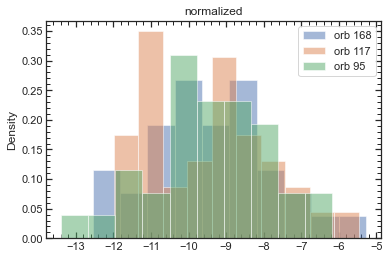

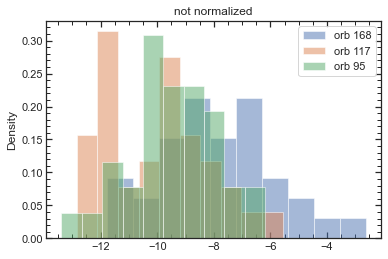

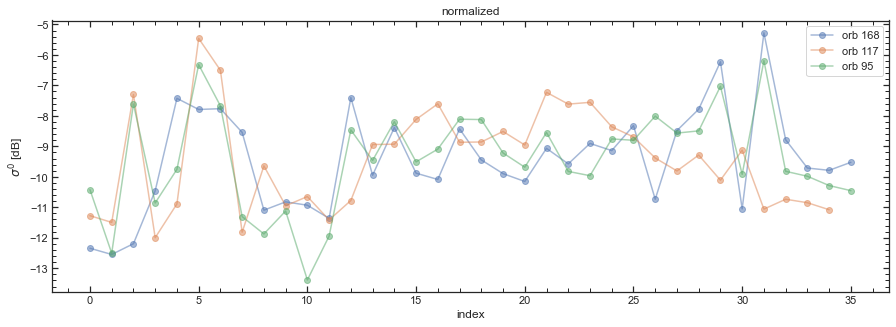

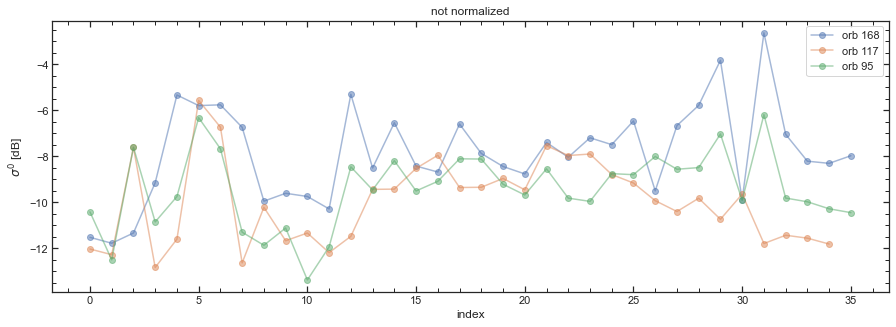

In [19]:
plot_name='sigma_norm_'

# Histograms plots
plt.figure()
for orb in [168, 117, 95]:
    plt.hist(nnormdf['VV'][orb], bins=10, alpha=.5, label=f'orb {orb}', density=True)
plt.ylabel('Density')
plt.legend(loc='best')
plt.title('normalized')
plt.savefig(plot_name+'hist_norm.png', dpi=300)
plt.show()

plt.figure()
for orb in [168, 117, 95]:
    plt.hist(normdf['VV'][orb], bins=10, alpha=.5, label=f'orb {orb}', density=True)
plt.ylabel('Density')
plt.legend(loc='best')
plt.title('not normalized')
plt.savefig(plot_name+'hist_not-norm.png', dpi=300)
plt.show()

# Timeseries
plt.figure(figsize=(15,5))
for orb in [168, 117, 95]:
    plt.plot(nnormdf['VV'][orb], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('normalized')
plt.savefig(plot_name+'plot_norm.png', dpi=300)
plt.show()

plt.figure(figsize=(15,5))
for orb in [168, 117, 95]:
    plt.plot(normdf['VV'][orb], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('not normalized')
plt.savefig(plot_name+'plot_not-norm.png', dpi=300)
plt.show()

In [6]:
df['VV_norm[dB]']= df.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VV_mean'][95],
        statsnorm['VV_std'][95],
        [   
            x['VV[dB]'],    
            statsnorm['VV_mean'][x.Orb],    
            statsnorm['VV_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

df['VH_norm[dB]']= df.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VH_mean'][95],
        statsnorm['VH_std'][95],
        [   
            x['VH[dB]'],    
            statsnorm['VH_mean'][x.Orb],    
            statsnorm['VH_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

In [7]:
df

,Angle[°],Date,Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],VV_norm[dB],VH_norm[dB]
0,31.282551,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,0.009136,0.000018,0.070329,0.000630,-11.528672,-20.392462,0.038881,0.008441,0.170173,0.0,0.0,8.7339,-12.343922,-20.828488
1,41.103306,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,0.006342,0.000010,0.090708,0.001534,-10.423533,-21.977589,0.073466,0.006573,0.147105,0.0,0.0,11.8548,-10.423533,-21.977589
2,37.537476,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,0.005942,0.000007,0.062548,0.000390,-12.037891,-22.260785,0.027052,0.004964,0.150527,0.0,0.0,15.6591,-11.275126,-21.874069
3,31.368000,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,0.006690,0.000009,0.066282,0.000831,-11.786029,-21.745415,0.054418,0.005718,0.159550,0.0,0.0,8.5507,-12.548264,-22.056497
4,41.305325,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,0.005057,0.000007,0.056139,0.000400,-12.507326,-22.961495,0.030916,0.005962,0.160673,0.0,0.0,10.5575,-12.507326,-22.961495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,41.293633,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,0.011202,0.000027,0.093611,0.000985,-10.286710,-19.507143,0.045695,0.010312,0.155637,0.0,0.0,5.1388,-10.286710,-19.507143
103,37.531326,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,0.012791,0.000031,0.069743,0.000667,-11.565022,-18.931034,0.041511,0.010434,0.155525,0.0,0.0,14.4822,-10.849906,-18.851762
104,31.386597,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,0.010243,0.000017,0.159341,0.004745,-7.976737,-19.895653,0.129336,0.007121,0.167105,0.0,0.0,4.9978,-9.523675,-20.377558
105,41.307350,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,0.011606,0.000018,0.090067,0.000921,-10.454340,-19.353215,0.044419,0.006885,0.124052,NaN,0.0,NaN,-10.454340,-19.353215


In [8]:
filename = f'..\\Data\\Golden_GEE.csv'
if input(f"Wanna save in Data directory? File has name: {filename}. [y/n] ")=='y':
    df.to_csv(filename, sep = '\t')

Wanna save in Data directory? File has name: ..\Data\Golden_GEE.csv. [y/n]  n
